In [1]:
import numpy as np
import pandas as pd
import warnings
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
warnings.filterwarnings("ignore")

In [3]:
# Load the datasets
movies = pd.read_csv("movies.csv")
credits = pd.read_csv("credits.csv")

In [5]:
# Check initial dataset info
print(movies.head())

   adult                              belongs_to_collection    budget  \
0  False  {'id': 10194, 'name': 'Toy Story Collection', ...  30000000   
1  False                                                NaN  65000000   
2  False  {'id': 119050, 'name': 'Grumpy Old Men Collect...         0   
3  False                                                NaN  16000000   
4  False  {'id': 96871, 'name': 'Father of the Bride Col...         0   

                                              genres  \
0  [{'id': 16, 'name': 'Animation'}, {'id': 35, '...   
1  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   
2  [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...   
3  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...   
4                     [{'id': 35, 'name': 'Comedy'}]   

                               homepage     id    imdb_id original_language  \
0  http://toystory.disney.com/toy-story    862  tt0114709                en   
1                                   NaN   8844  tt0113497         

In [6]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

In [7]:
# Remove rows with dates in the 'id' column
date_pattern = r'^\d{4}-\d{2}-\d{2}$'
movies.drop(movies[movies['id'].str.match(date_pattern, na=False)].index, inplace=True)
movies["id"] = movies["id"].astype(int)

In [8]:
# Merge movies and credits datasets
movies = movies.merge(credits, on="id")

In [9]:
# Retain only the relevant columns
movies = movies[["id", "title", "overview", "genres", "cast", "crew"]]

In [10]:
# Handle missing values
movies.dropna(subset=["title"], inplace=True)
movies['overview'].fillna(method='bfill', inplace=True)
movies['overview'].fillna(method='ffill', inplace=True)

In [11]:
# Functions to convert stringified list columns into list of names
def convert(text):
    L = []
    for i in ast.literal_eval(text):
        L.append(i["name"])
    return L

def fetch_director(text):
    L = []
    for i in ast.literal_eval(text):
        if i["job"] == "Director":
            L.append(i["name"])
    return L

In [12]:
# Apply the conversion functions
movies["genres"] = movies["genres"].apply(convert)
movies["cast"] = movies["cast"].apply(convert)
movies["crew"] = movies["crew"].apply(fetch_director)

In [13]:
# Combine features into a single 'tags' column
movies.overview = movies["overview"].astype("str")
movies["overview"] = movies["overview"].apply(lambda x: x.split())
movies["tags"] = movies["overview"] + movies["genres"] + movies["cast"] + movies["crew"]

In [14]:

# Create a new dataframe with essential columns
new_df = movies[["id", "title", "tags"]]
new_df["tags"] = new_df["tags"].apply(lambda x: " ".join(x))
new_df["tags"] = new_df["tags"].apply(lambda x: x.lower())

In [ ]:
#Additional Text Processing: Stemming
ps = PorterStemmer()

def stem_text(text):
    return " ".join([ps.stem(word) for word in text.split()])

new_df["tags"] = new_df["tags"].apply(stem_text)

In [ ]:
#Genre Distribution: Flatten the genres list and count occurrences
all_genres = movies["genres"].explode()
genre_counts = all_genres.value_counts()

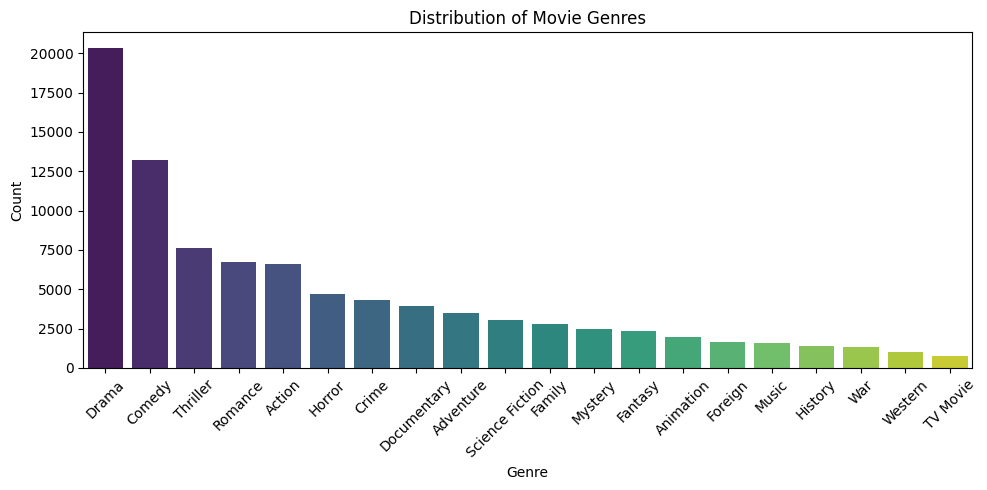

In [17]:
plt.figure(figsize=(10, 5))
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette="viridis")
plt.title("Distribution of Movie Genres")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

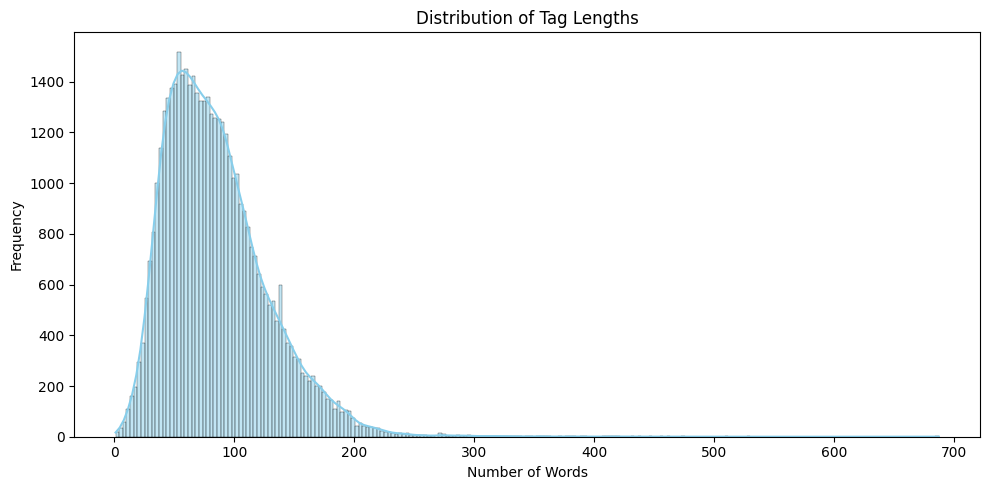

In [18]:
#Plot sample tag length distribution to see how many words are used per movie 
new_df["tag_length"] = new_df["tags"].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 5))
sns.histplot(new_df["tag_length"], kde=True, color="skyblue")
plt.title("Distribution of Tag Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [ ]:
#Recommendation Engine using TF-IDF Vectorizer 
tfidf = TfidfVectorizer(max_features=5000, stop_words="english")
vectors = tfidf.fit_transform(new_df["tags"]).toarray()
print("Vector shape:", vectors.shape)

Vector shape: (45535, 5000)


In [20]:
# Calculate cosine similarity between movies
similarity = cosine_similarity(vectors)

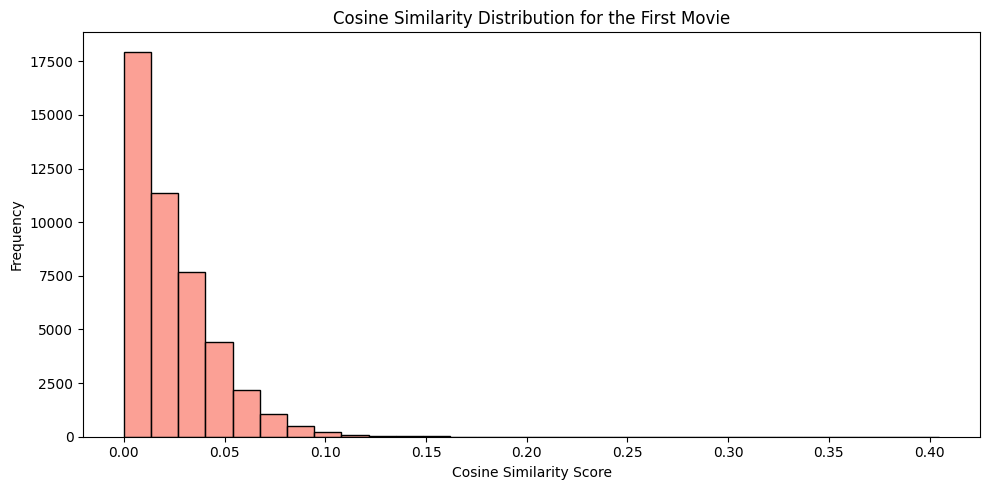

In [21]:
# Visualize the distribution of cosine similarity scores for the first movie
plt.figure(figsize=(10, 5))
sns.histplot(similarity[0][1:], bins=30, color="salmon")
plt.title("Cosine Similarity Distribution for the First Movie")
plt.xlabel("Cosine Similarity Score")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [22]:
# Recommendation function
def recommend(movie):
    try:
        index = new_df[new_df["title"].str.lower() == movie.lower()].index[0]
    except IndexError:
        print("Movie not found in the dataset!")
        return
    distances = sorted(list(enumerate(similarity[index])), reverse=True, key=lambda x: x[1])
    print(f"Recommendations for '{new_df.iloc[index].title}':")
    for i in distances[1:6]:
        print(new_df.iloc[i[0]].title)

In [26]:
# Test the recommendation system
recommend("Toy Story")

Recommendations for 'Toy Story':
Toy Story 2
Crisis in Six Scenes
Toy Story 3
What's Up, Tiger Lily?
Shadows and Fog
